# Indicação de Prestadores
## Estudos dos comportamentos: Consulta e Pronto Socorro

#### Autora: Patricia Novais

Entender qual é o comportamento 'comum' entre crianças de 0 a 12 anos de idade que utilizam os serviços de saúde da SulAmérica, tanto em Consultas Eletivas quanto em Consultas no Pronto Socorro.

Para isso, estamos analisando a frequência de uso desses serviços e buscando insights para entendermos melhor como trabalhar tal público.

In [1]:
import matplotlib
matplotlib.use('Agg')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
import time
import datetime
import bz2
import pylab
import glob, os    

from dateutil.relativedelta import relativedelta
from datetime import date
from scipy.optimize import curve_fit
from scipy import stats


In [3]:
ini=time.time()

In [4]:
plt.style.use('ggplot')
%matplotlib inline

pd.options.display.max_columns = 101

In [5]:
def value_hist(freq, corte, binss=20):
    freq = freq[freq.contagem < corte]
    count, division = np.histogram(freq.contagem,bins=binss)
    a = list(zip(division,count))

    hist = pd.DataFrame(a,columns=['division','count'])

    xx = hist.division.values
    yy = hist['count'].values
    return(xx,yy,hist)

In [6]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Consultas

### Preparação e Limpeza dos Dados

In [7]:
df= pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "data/Match_Patient_Consultas_Eletivas_2017_Indicacao_Prestadores_00000000000*.csv"))))

# Selecionando apenas as CONSULTAS
df = df[df.DESC_GRUPO == 'CONSULTA']

df_reemb = df[df.TIPO_PAGAMENTO=='REEMBOLSO']

df = df[df.TIPO_PAGAMENTO!='REEMBOLSO']

# Transformando as datas
df.loc[:,'DAT_ATENDIMENTO_EFETIVO'] = pd.to_datetime(df.loc[:,'DAT_ATENDIMENTO_EFETIVO'], dayfirst=True)
df.loc[:,'DAT_PRIMEIRA_CONSULTA_CC'] = pd.to_datetime(df.loc[:,'DAT_PRIMEIRA_CONSULTA_CC'], dayfirst=True)

df.index = df.DAT_ATENDIMENTO_EFETIVO
df['Data'] = df['DAT_ATENDIMENTO_EFETIVO']

# Transformando o CRM para int e substituindo os NaN por -999999
df.CRM_SOLICITANTE = df.CRM_SOLICITANTE.fillna(-999999).astype(int)
df.CRM_EXECUTANTE = df.CRM_EXECUTANTE.fillna(-999999).astype(int)

In [8]:
df.CRM_SOLICITANTE = df.CRM_SOLICITANTE.astype(str)
df.CRM_EXECUTANTE = df.CRM_EXECUTANTE.astype(str)

### Sazonalidade das Consultas

In [9]:
min_data = df.DAT_ATENDIMENTO_EFETIVO.min()
max_data = df.DAT_ATENDIMENTO_EFETIVO.max()

print('*'*100)
print('Quantidade de registros de CONSULTAS: %d' %len(df))
print(min_data.strftime('Data mínima: %Y-%m-%d'))
print(max_data.strftime('Data máxima: %Y-%m-%d'))
print('*'*100)

****************************************************************************************************
Quantidade de registros de CONSULTAS: 443181
Data mínima: 2017-01-01
Data máxima: 2019-01-24
****************************************************************************************************


In [10]:
freq_mes = df.resample('M').count()
freq_mes['mês'] = freq_mes.index

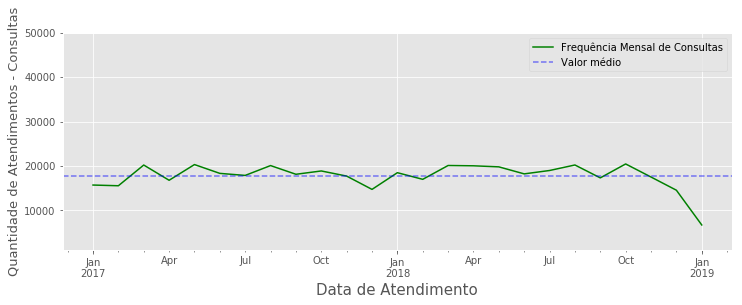

In [11]:
plt.figure(figsize=(12,4))
freq_mes.COD_BENEFICIARIO.plot(color='green', label='Frequência Mensal de Consultas')
plt.ylim(1000,50000)
plt.ylabel('Quantidade de Atendimentos - Consultas',fontsize=13)
plt.xlabel('Data de Atendimento', fontsize=15)
plt.axhline(y=17727, alpha = 0.5, label = 'Valor médio',color='blue', linestyle='--')
plt.legend()

In [12]:
print('Frequência média de atendimentos mensais: %d' %freq_mes.COD_BENEFICIARIO.mean())
print('Variação de atendimentos mensais: %d' %freq_mes.COD_BENEFICIARIO.std())

Frequência média de atendimentos mensais: 17727
Variação de atendimentos mensais: 2906


Nota-se que a quantidade de atendimentos em consulta eletiva ao longo do período permaneceu **aproximadamente constante**, sem quedas ou aumentos abruptos. 

> a menor quantidade de atendimentos contabilizados em janeiro/19 se deve ao fato de as contas desse período ainda não estarem 100% processadas.

### Trabalhando as Frequências de Uso - CONSULTAS

In [13]:
freq_cons = pd.DataFrame(df.COD_BENEFICIARIO.value_counts().reset_index())
freq_cons.columns = ['COD_BENEFICIARIO', 'contagem']
display(freq_cons.head(5))

COD_BENEFICIARIO  contagem
0  8COV845502667010        86
1  3048600267616010        80
2  0055900054012010        63
3  8ANR845783195010        62
4  0900140459070010        60

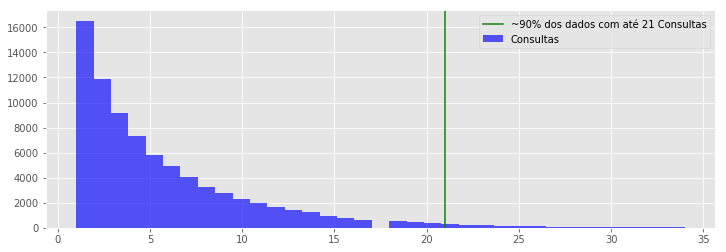

In [14]:
plt.figure(figsize=(12,4))
freq_cons[freq_cons['contagem']<35].contagem.hist(bins=35,label = 'Consultas', alpha=0.65, density=False, color='blue')
plt.axvline(x=21, alpha = 0.95, label = '~90% dos dados com até 21 Consultas', color='green')
plt.legend()

Considerando os dados obtidos, nota-se que cerca de 90% dos segurados utilizaram os serviços de consulta eletiva em até **21 vezes** nos últimos dois anos.

##### Ajuste exponencial - Consultas

In [15]:
np.random.seed(12345678)
xx_cons, yy_cons, hist_cons = value_hist(freq_cons,40,40)
#def value_hist(freq, corte, binss=20)

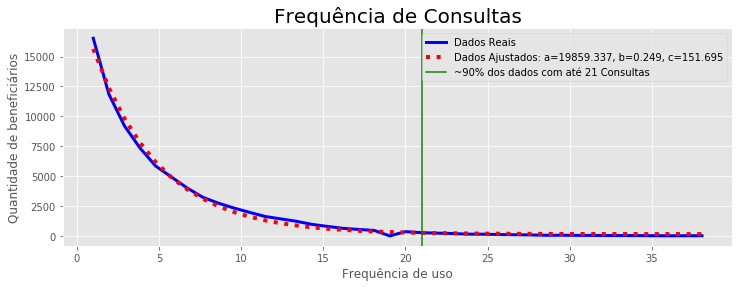

In [16]:
popt_cons, pcov_cons = curve_fit(func, xx_cons, yy_cons)

plt.figure(figsize=(12,4))
plt.plot(xx_cons, yy_cons, 'b-', label='Dados Reais',linewidth=3, alpha=1)
plt.plot(xx_cons, func(xx_cons, *popt_cons), 'r:',label='Dados Ajustados: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_cons),linewidth=4)
plt.axvline(x=21, alpha = 0.95, label = '~90% dos dados com até 21 Consultas', color='green')
#plt.xlim(7,12)
#plt.ylim(0,10000)
plt.xlabel('Frequência de uso')
plt.ylabel('Quantidade de beneficiários')
plt.title('Frequência de Consultas', fontsize=20)
plt.legend()

> ~90% dos beneficiários utilizaram os serviços de saúde até 21 vezes.

#### Analisando Frequências > 21 consultas

In [17]:
freq_cons30 = freq_cons[freq_cons.contagem>21]
freq_consmenos30 = freq_cons[freq_cons.contagem<21]

len(freq_consmenos30)

78062

In [18]:
df_30 = pd.merge(df, freq_cons30, on=['COD_BENEFICIARIO'], how='inner')
df_menos30 = pd.merge(df, freq_consmenos30, on=['COD_BENEFICIARIO'], how='inner')

In [19]:
df_30.index = df_30.DAT_ATENDIMENTO_EFETIVO

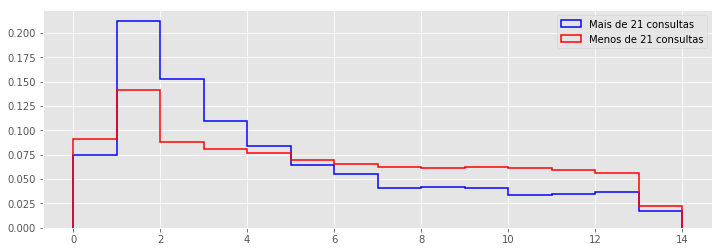

In [20]:
plt.figure(figsize=(12,4))
df_30.QTD_IDADE.hist(density=True, label='Mais de 21 consultas', bins=14,linestyle=('solid'),
                                              histtype='step',linewidth=1.5, color='blue')
df_menos30.QTD_IDADE.hist(density=True, label='Menos de 21 consultas', bins=14,linestyle=('solid'),
                                              histtype='step',linewidth=1.5, color='red')
plt.legend()

In [21]:
print('*'*100)
print('média de idade dos segurados com mais de 30 consultas: %3.1f' %df_30.QTD_IDADE.mean())
print('média de idade dos segurados com menos de 30 consultas: %3.1f' %df_menos30.QTD_IDADE.mean())

print('*'*100)
print('desvio padrão de idade dos segurados com mais de 30 consultas: %3.1f' %df_30.QTD_IDADE.std())
print('desvio padrão idade dos segurados com menos de 30 consultas: %3.1f' %df_menos30.QTD_IDADE.std())

print('*'*100)
print('mediana de idade dos segurados com mais de 30 consultas: %3.1f' %df_30.QTD_IDADE.median())
print('mediana de idade dos segurados com menos de 30 consultas: %3.1f' %df_menos30.QTD_IDADE.median())
print('*'*100)

****************************************************************************************************
média de idade dos segurados com mais de 30 consultas: 4.2
média de idade dos segurados com menos de 30 consultas: 5.3
****************************************************************************************************
desvio padrão de idade dos segurados com mais de 30 consultas: 3.6
desvio padrão idade dos segurados com menos de 30 consultas: 3.9
****************************************************************************************************
mediana de idade dos segurados com mais de 30 consultas: 3.0
mediana de idade dos segurados com menos de 30 consultas: 5.0
****************************************************************************************************


É interessante notar que os **hiper consultadores** (> *21 consultas* no período) tem maior concentração entre os segurados de menor idade (média=4.2 e mediana=3.0)

C:\Users\p135894\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


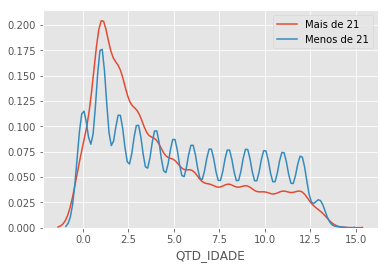

In [22]:
x = df_30.loc[:,'QTD_IDADE']
sns.distplot(x, label='Mais de 21',hist=False,bins=14)
xx = df_menos30.loc[:,'QTD_IDADE']
sns.distplot(xx, label='Menos de 21',hist=False,bins=14)
plt.legend()

## Pronto Socorro

### Preparação e Limpeza dos Dados

In [23]:
df_ps = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "data/Match_Patient_Consultas_PS_Indicacao_Prestadores_00000000000*.csv"))))

# Selecionando apenas CONSULTA, uma vez que nos interessa por hora apenas saber se o segurado utilizou ou não o PS, sem nos preocupar 
#se a consulta gerou custos extras ou não
df_ps = df_ps[df_ps.DESC_GRUPO == 'CONSULTA']

# Seleção apenas os PS que não foram Reembolso, visto que esse tipo de ação não será possível de rastrear em tempo hábil para indicar
# melhores prestadores
df_ps = df_ps[df_ps.TIPO_PAGAMENTO!='REEMBOLSO']

# Transformando as datas
df_ps.loc[:,'DAT_ATENDIMENTO_EFETIVO'] = pd.to_datetime(df_ps.loc[:,'DAT_ATENDIMENTO_EFETIVO'], dayfirst=True)
df_ps.loc[:,'DAT_PRIMEIRA_CONSULTA_CC'] = pd.to_datetime(df_ps.loc[:,'DAT_PRIMEIRA_CONSULTA_CC'], dayfirst=True)

df_ps.index = df_ps.DAT_ATENDIMENTO_EFETIVO
df_ps['Data'] = df_ps['DAT_ATENDIMENTO_EFETIVO']


C:\Users\p135894\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
min_data = df_ps.DAT_ATENDIMENTO_EFETIVO.min()
max_data = df_ps.DAT_ATENDIMENTO_EFETIVO.max()

print('*'*100)
print('Quantidade de registros de PRONTO SOCORRO: %d' %len(df_ps))
print(min_data.strftime('Data mínima: %Y-%m-%d'))
print(max_data.strftime('Data máxima: %Y-%m-%d'))
print('*'*100)

****************************************************************************************************
Quantidade de registros de PRONTO SOCORRO: 471118
Data mínima: 2017-01-01
Data máxima: 2019-01-22
****************************************************************************************************


### Sazonalidade do Pronto Socorro

In [25]:
min_data = df_ps.DAT_ATENDIMENTO_EFETIVO.min()
max_data = df_ps.DAT_ATENDIMENTO_EFETIVO.max()

print('*'*100)
print('Quantidade de registros de PRONTO SOCORRO: %d' %len(df_ps))
print(min_data.strftime('Data mínima: %Y-%m-%d'))
print(max_data.strftime('Data máxima: %Y-%m-%d'))
print('*'*100)

****************************************************************************************************
Quantidade de registros de PRONTO SOCORRO: 471118
Data mínima: 2017-01-01
Data máxima: 2019-01-22
****************************************************************************************************


In [26]:
freq_mes_ps = df_ps.resample('M').count()
freq_mes_ps['mês'] = freq_mes_ps.index

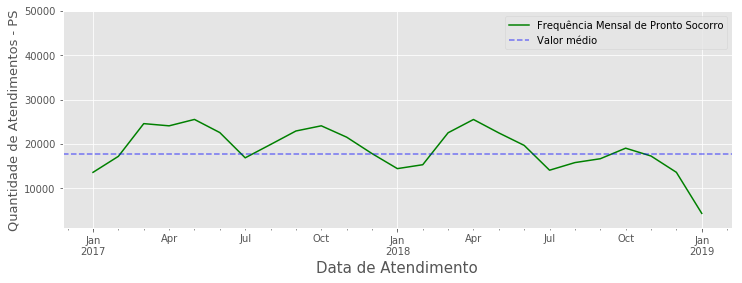

In [27]:
plt.figure(figsize=(12,4))
freq_mes_ps.COD_BENEFICIARIO.plot(color='green', label='Frequência Mensal de Pronto Socorro')
plt.ylim(1000,50000)
plt.ylabel('Quantidade de Atendimentos - PS',fontsize=13)
plt.xlabel('Data de Atendimento', fontsize=15)
plt.axhline(y=17727, alpha = 0.5, label = 'Valor médio',color='blue', linestyle='--')
plt.legend()

In [28]:
print('Frequência média de atendimentos mensais: %d' %freq_mes_ps.COD_BENEFICIARIO.mean())
print('Variação de atendimentos mensais: %d' %freq_mes_ps.COD_BENEFICIARIO.std())
print('Máximo atendimentos mensais: %d' %freq_mes_ps.COD_BENEFICIARIO.max())
print('Mínimo de atendimentos mensais: %d' %freq_mes_ps.COD_BENEFICIARIO.min())

Frequência média de atendimentos mensais: 18844
Variação de atendimentos mensais: 4942
Máximo atendimentos mensais: 25510
Mínimo de atendimentos mensais: 4345


Ao contrário do observado com Consultas Eletivas, nota-se que a quantidade de atendimentos em Pronto Socorro ao longo do período exibe uma sazonalidade, tendo sido realizados até mais de 25000 atendidos num mês. 

> É válido buscar informações sobre as causas das sazonalidades e entender se pode ou não existir algum fator que esteja deslocando os picos de atendimentos, uma vez que seria esperado picos em estações climáticas intensas como verão e inverno.

### Trabalhando as Frequências de Uso - PRONTO SOCORRO

In [29]:
freq_ps = pd.DataFrame(df_ps.COD_BENEFICIARIO.value_counts().reset_index())
freq_ps.columns = ['COD_BENEFICIARIO', 'contagem']
display(freq_ps.head(5))

COD_BENEFICIARIO  contagem
0  0029600391202010       118
1  0029400353779010       107
2  8353500283535010       101
3  0029400324276011        94
4  0029600490755010        81

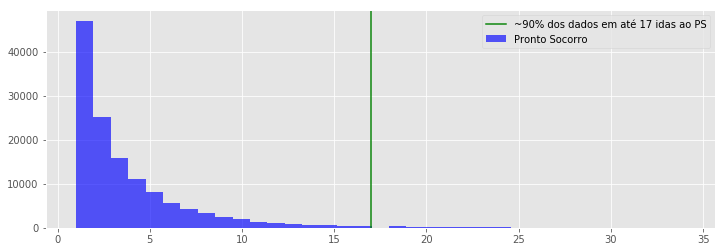

In [30]:
plt.figure(figsize=(12,4))
freq_ps[freq_ps['contagem']<35].contagem.hist(bins=35,label = 'Pronto Socorro', alpha=0.65, density=False, color='blue')
plt.axvline(x=17, alpha = 0.95, label = '~90% dos dados em até 17 idas ao PS', color='green')
plt.legend()

Considerando os dados obtidos, nota-se que cerca de 90% dos segurados utilizaram os serviços de Pronto Socorro até **17 vezes** nos últimos dois anos.

##### Ajuste exponecial - Pronto Socorro

In [31]:
np.random.seed(12345678)
xx_ps, yy_ps, hist_ps = value_hist(freq_ps,40,40)
#def value_hist(freq, corte, binss=20)

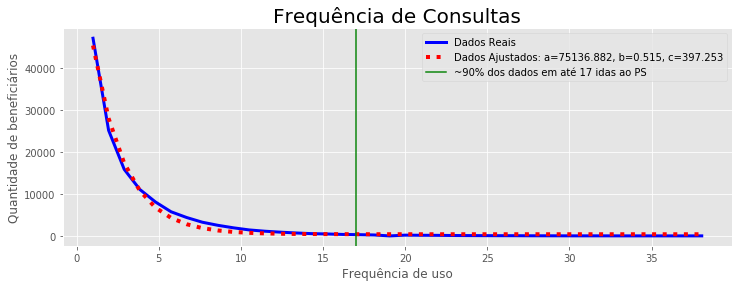

In [32]:
popt_ps, pcov_ps = curve_fit(func, xx_ps, yy_ps)

plt.figure(figsize=(12,4))
plt.plot(xx_ps, yy_ps, 'b-', label='Dados Reais',linewidth=3, alpha=1)
plt.plot(xx_ps, func(xx_ps, *popt_ps), 'r:',label='Dados Ajustados: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_ps),linewidth=4)
plt.axvline(x=17, alpha = 0.95, label = '~90% dos dados em até 17 idas ao PS', color='green')
#plt.xlim(7,12)
#plt.ylim(0,10000)
plt.xlabel('Frequência de uso')
plt.ylabel('Quantidade de beneficiários')
plt.title('Frequência de Consultas', fontsize=20)
plt.legend()

#### Analisando Frequências > 17 consultas

In [33]:
freq_ps17 = freq_ps[freq_ps.contagem>17]
freq_psmenos17 = freq_ps[freq_ps.contagem<17]

len(freq_psmenos17)

130039

In [34]:
df_ps_17 = pd.merge(df, freq_ps17, on=['COD_BENEFICIARIO'], how='inner')
df_ps_menos17 = pd.merge(df, freq_psmenos17, on=['COD_BENEFICIARIO'], how='inner')

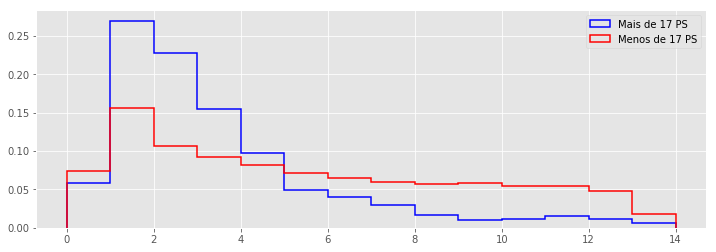

In [35]:
plt.figure(figsize=(12,4))
df_ps_17.QTD_IDADE.hist(density=True, label='Mais de 17 PS', bins=14,linestyle=('solid'),
                                              histtype='step',linewidth=1.5, color='blue')
df_ps_menos17.QTD_IDADE.hist(density=True, label='Menos de 17 PS', bins=14,linestyle=('solid'),
                                              histtype='step',linewidth=1.5, color='red')
plt.legend()

In [36]:
print('*'*100)
print('média de idade dos segurados com mais de 30 consultas: %3.1f' %df_ps_17.QTD_IDADE.mean())
print('média de idade dos segurados com menos de 30 consultas: %3.1f' %df_ps_menos17.QTD_IDADE.mean())

print('*'*100)
print('desvio padrão de idade dos segurados com mais de 30 consultas: %3.1f' %df_ps_17.QTD_IDADE.std())
print('desvio padrão idade dos segurados com menos de 30 consultas: %3.1f' %df_ps_menos17.QTD_IDADE.std())

print('*'*100)
print('mediana de idade dos segurados com mais de 30 consultas: %3.1f' %df_ps_17.QTD_IDADE.median())
print('mediana de idade dos segurados com menos de 30 consultas: %3.1f' %df_ps_menos17.QTD_IDADE.median())
print('*'*100)

****************************************************************************************************
média de idade dos segurados com mais de 30 consultas: 3.0
média de idade dos segurados com menos de 30 consultas: 5.1
****************************************************************************************************
desvio padrão de idade dos segurados com mais de 30 consultas: 2.6
desvio padrão idade dos segurados com menos de 30 consultas: 3.8
****************************************************************************************************
mediana de idade dos segurados com mais de 30 consultas: 2.0
mediana de idade dos segurados com menos de 30 consultas: 4.0
****************************************************************************************************


É interessante notar que os **hiper consultadores** (> *17 consultas* no período) tem maior concentração entre os segurados de menor idade (média=3.0 e mediana=2.0)

C:\Users\p135894\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


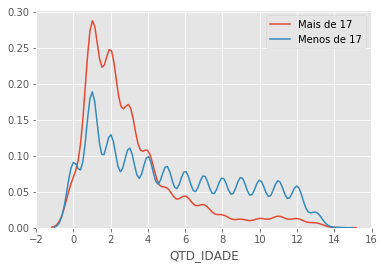

In [37]:
x = df_ps_17.loc[:,'QTD_IDADE']
sns.distplot(x, label='Mais de 17',hist=False,bins=14)
xx = df_ps_menos17.loc[:,'QTD_IDADE']
sns.distplot(xx, label='Menos de 17',hist=False,bins=14)
plt.legend()

##### Fazendo uma comparação entre as frequência de CONSULTAS e PS

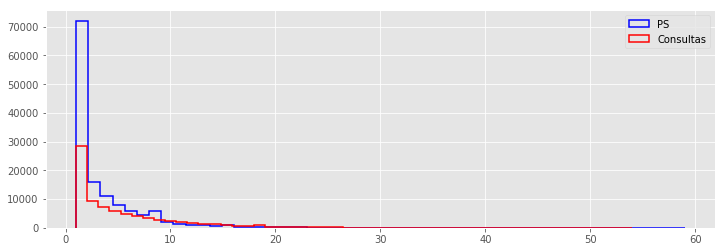

In [38]:
plt.figure(figsize=(12,4))
freq_ps[freq_ps['contagem']<60].contagem.hist(bins=50, label='PS', linestyle=('solid'),
                                              histtype='step',linewidth=1.5, color='blue')
freq_cons[freq_cons['contagem']<60].contagem.hist(bins=50, label='Consultas', linestyle=('solid'),
                                                  histtype='step',linewidth=1.5, color='red')
plt.legend()

> **Zoom:**

Text(0.5, 1.0, 'Zoom: Frequências CONSULTA X PRONTO SOCORRO')

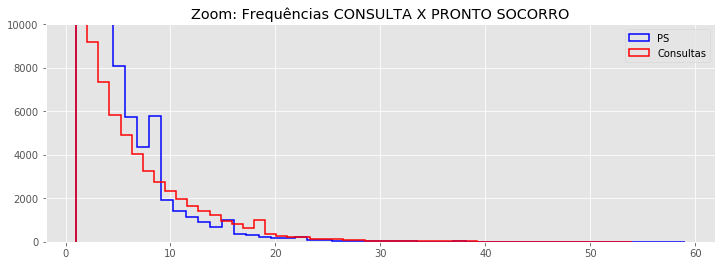

In [39]:
plt.figure(figsize=(12,4))
freq_ps[freq_ps['contagem']<60].contagem.hist(bins=50, label='PS', linestyle=('solid'),
                                              histtype='step',linewidth=1.5, color='blue')
freq_cons[freq_cons['contagem']<60].contagem.hist(bins=50, label='Consultas', linestyle=('solid'),
                                                  histtype='step',linewidth=1.5, color='red')
plt.legend()
plt.ylim(0,10000)
plt.title('Zoom: Frequências CONSULTA X PRONTO SOCORRO')

Nota-se que a frequência de uso do Pronto Socorro supera as de Consultas Eletivas até em torno de 10x, frequência a partir da qual a quantidade de consultas supera as de PS.

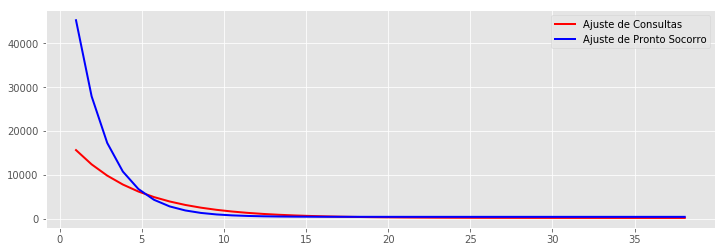

In [40]:
plt.figure(figsize=(12,4))
plt.plot(xx_cons, func(xx_cons, *popt_cons), 'r-',label='Ajuste de Consultas',linewidth=2)
plt.plot(xx_ps, func(xx_ps, *popt_ps), 'b-',label='Ajuste de Pronto Socorro',linewidth=2)
plt.legend()

Comparando os ajustes exponenciais de ambos, confirma-se que a frequência do PS é superior a de Consultas eletivas, tendo uma taxa de decaimento maior do que a de consultas.

### Alguns Insights Interessantes

Considerando-se apenas as Consultas Eletivas e as de Pronto Socorro, vale ressaltar que:
- Há um **decaimento exponencial** da frequência com que os segurados entre 0 e 12 anos utilizam ambos os serviços
- ~90 dos segurados realizam até **21** consultas e até **17** idas ao PS
- Dentre os aqui chamados '**hiper consultadores**', a maior parte se concentra em **menores idades** (média em torno de 4 para Consultas e 3 para PS)
- A quantidade de segurados que utilizam Pronto Socorro é maior do que para Consultas até em torno de 9x, a partir da qual se torna maior a quantidade de consultas.


### Algumas possibilidades a explorar
- Quantos e quais segurados estão em ambas as bases? 
- Quais as frequências de Consulta e PS desses segurados?
- Quais as especialidades mais consultadas em Consulta e PS?
- Há comportamentos suspeitos entre os hiper consultadores?
- Explorar internação.

### Cuidado Coordenado

Entendimento de qual a influência do programa Cuidado Coordenado no comportamento dos segurados

In [41]:
df_cc = df[df.DSC_STATUS_CUIDADO_COORDENADO == 'COM CUIDADO COORDENADO']
df_cc.index = df_cc.DAT_PRIMEIRA_CONSULTA_CC

In [42]:
freq_mes_cc = df_cc.resample('M').count()
freq_mes_cc['mês'] = freq_mes_cc.index

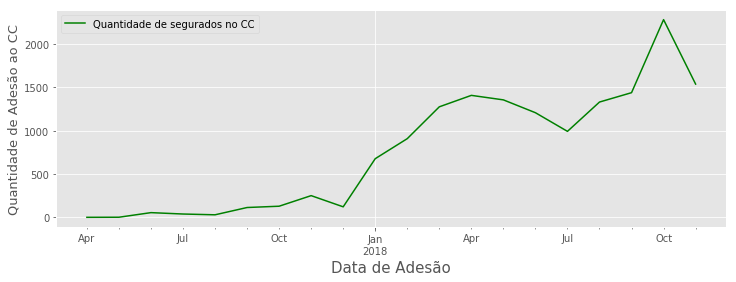

In [43]:
plt.figure(figsize=(12,4))
freq_mes_cc.COD_BENEFICIARIO.plot(color='green', label='Quantidade de segurados no CC')
#plt.ylim(1000,50000)
plt.ylabel('Quantidade de Adesão ao CC',fontsize=13)
plt.xlabel('Data de Adesão', fontsize=15)
#plt.axhline(y=606, alpha = 0.5, label = 'Valor médio',color='blue', linestyle='--')
plt.legend()

A quantidade de segurados no Cuidado Coordenado foi aumentando gradativamente nos últimos dois anos.

> Como a adesão ao Cuidado Coordenado influenciou o comportamento dos segurados?

Para isso, iremos comparar o comportamento dos segurados que tiveram muitas consultas no período.

In [44]:
print('*'*100)
print('Quantidade de registros de uso - segurados no CC: %d registros' %len(df_cc))
print('Quantidade de segurados únicos no CC: %d segurados' %df_cc.COD_BENEFICIARIO.nunique())

****************************************************************************************************
Quantidade de registros de uso - segurados no CC: 15149 registros
Quantidade de segurados únicos no CC: 1918 segurados


In [45]:
freq_mes_cc.COD_BENEFICIARIO.mean()

757.45

In [46]:
#df_cc_21 = pd.merge(df, df_cc, on=['COD_BENEFICIARIO'], how='inner')
df_cc_freq = pd.merge(df_cc, freq_cons, on=['COD_BENEFICIARIO'], how='inner')

In [47]:
freq_cc = pd.DataFrame(df_cc.COD_BENEFICIARIO.value_counts().reset_index())
freq_cc.columns = ['COD_BENEFICIARIO', 'contagem']
display(freq_cc.head(3))

COD_BENEFICIARIO  contagem
0  2668926689002010        53
1  0068000054430010        51
2  0068000640953010        48

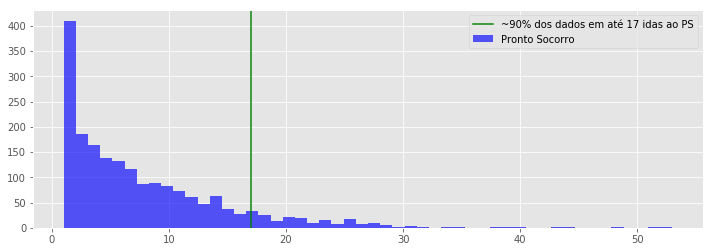

In [48]:
plt.figure(figsize=(12,4))
freq_cc.contagem.hist(bins=50,label = 'Pronto Socorro', alpha=0.65, density=False, color='blue')
plt.axvline(x=17, alpha = 0.95, label = '~90% dos dados em até 17 idas ao PS', color='green')
plt.legend()

In [49]:
freq_cc[freq_cc['contagem'] < 26].contagem.sum()/freq_cc.contagem.sum()

0.9061324179813849

In [50]:
df_a_cc = df_cc[df_cc.DAT_ATENDIMENTO_EFETIVO < df_cc.DAT_PRIMEIRA_CONSULTA_CC]
df_d_cc = df_cc[df_cc.DAT_ATENDIMENTO_EFETIVO > df_cc.DAT_PRIMEIRA_CONSULTA_CC]

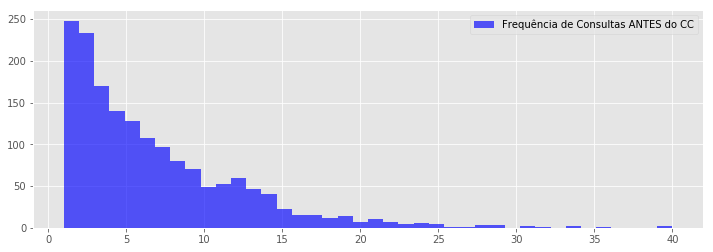

In [51]:
freq_a_cc = pd.DataFrame(df_a_cc.COD_BENEFICIARIO.value_counts().reset_index())
freq_a_cc.columns = ['COD_BENEFICIARIO', 'contagem']
#display(freq_cc.head(5))

plt.figure(figsize=(12,4))
freq_a_cc.contagem.hist(bins=40,label = 'Frequência de Consultas ANTES do CC', alpha=0.65, density=False, color='blue')
plt.legend()

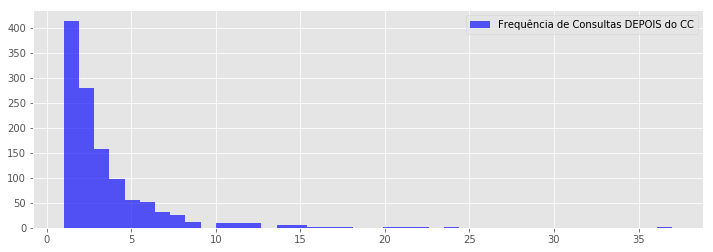

In [52]:
freq_d_cc = pd.DataFrame(df_d_cc.COD_BENEFICIARIO.value_counts().reset_index())
freq_d_cc.columns = ['COD_BENEFICIARIO', 'contagem']
#display(freq_cc.head(5))

plt.figure(figsize=(12,4))
freq_d_cc.contagem.hist(bins=40,label = 'Frequência de Consultas DEPOIS do CC', alpha=0.65, density=False, color='blue')
plt.legend()

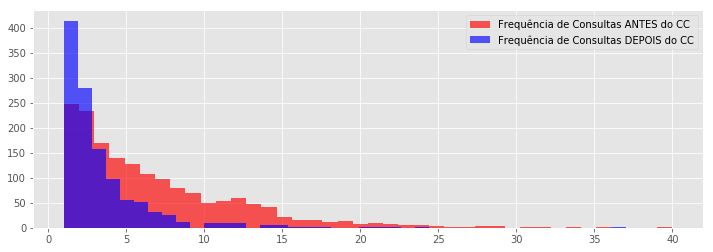

In [53]:
freq_d_cc = pd.DataFrame(df_d_cc.COD_BENEFICIARIO.value_counts().reset_index())
freq_d_cc.columns = ['COD_BENEFICIARIO', 'contagem']
#display(freq_cc.head(5))

plt.figure(figsize=(12,4))
freq_a_cc.contagem.hist(bins=40,label = 'Frequência de Consultas ANTES do CC', alpha=0.65, density=False, color='red')
freq_d_cc.contagem.hist(bins=40,label = 'Frequência de Consultas DEPOIS do CC', alpha=0.65, density=False, color='blue')
plt.legend()

É notável a diferença observada no comportamento dos segurados após a adesão ao Cuidado Coordenado, em que observa-se uma diminuição significativa na frequência de Consultas.

In [54]:
df_a_cc.index = df_a_cc.DAT_ATENDIMENTO_EFETIVO
df_d_cc.index = df_d_cc.DAT_ATENDIMENTO_EFETIVO

In [55]:
freq_mes_a_cc = df_a_cc.resample('M').count()
freq_mes_d_cc = df_d_cc.resample('M').count()
#freq_mes_cc['mês'] = freq_mes_cc.index

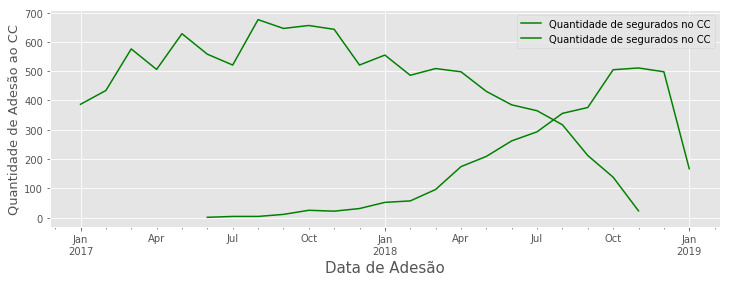

In [56]:
plt.figure(figsize=(12,4))
freq_mes_a_cc.COD_BENEFICIARIO.plot(color='green', label='Quantidade de segurados no CC')
freq_mes_d_cc.COD_BENEFICIARIO.plot(color='green', label='Quantidade de segurados no CC')
#plt.ylim(1000,50000)
plt.ylabel('Quantidade de Adesão ao CC',fontsize=13)
plt.xlabel('Data de Adesão', fontsize=15)
#plt.axhline(y=606, alpha = 0.5, label = 'Valor médio',color='blue', linestyle='--')
plt.legend()

### Cuidado Coordenado - Mesmo?

> Os segurados que são sinalizados como Cuidado Coordenado estão utilizando os médicos do Cuidado Coordenado?

In [57]:
# Base com os CRMs dos médicos do CC
df_crm_cc = pd.read_excel('data/medicos_cuidado_coordenado.xlsx', sheet_name='crms')
df_crm_cc.columns = ['Nome da conta', 'Sobrenome', 'CRM_EXECUTANTE', 'Código do prestador',
       'CNPJ', 'Especialidade', 'Telefone', 'Rua de cobrança',
       'Cidade de cobrança', 'Estado/Província de cobrança']

In [58]:
df_crm_cc.head(2)

Nome da conta                          Sobrenome  \
0  CL DE NEUR DR PAULO EDUARDO TAVARES  PAULO EDUARDO TAVARES DE OLIVEIRA   
1  CEBOT CENT BUTANTA ORT TRAUMAT LTDA           FERNANDO MACHADO PEDROSA   

  CRM_EXECUTANTE Código do prestador            CNPJ  Especialidade  \
0          54182        100000012918  26104453000151  Neurocirurgia   
1          40081        719301190001  71930119000101      Ortopedia   

                          Telefone  \
0                   (11) 2295-0119   
1  (11) 3032-1811 / (11) 3032-1050   

                                     Rua de cobrança Cidade de cobrança  \
0                 R MANUEL DE AUTOGUIA, 20 - TATUAPÉ          SÃO PAULO   
1  R PROFESSOR ARTUR RAMOS, 96 7 AND CJ 72 A - JA...          SÃO PAULO   

  Estado/Província de cobrança  
0                           SP  
1                           SP

In [59]:
# Base com registros de consultas feitas com médicos dentro do CC
tem_cc = pd.merge(df_d_cc, df_crm_cc, on=['CRM_EXECUTANTE'], how='inner')

In [60]:
print('Quantidade de atendimentos após inserção no CC: %d' %len(df_d_cc))
print('Quantidade de atendimentos efetivamente realizados com médicos do CC: %d' %len(tem_cc))
print('Apenas %2.2f%% das consultas feitas por quem está no CC realmente foram com médicos do CC.' %(100*(len(tem_cc)/len(df_d_cc))))

Quantidade de atendimentos após inserção no CC: 3654
Quantidade de atendimentos efetivamente realizados com médicos do CC: 504
Apenas 13.79% das consultas feitas por quem está no CC realmente foram com médicos do CC.


In [61]:
freq_crm_cc = pd.DataFrame(tem_cc.CRM_EXECUTANTE.value_counts().reset_index())
freq_crm_cc.columns = ['CRM_EXECUTANTE', 'contagem']
display(freq_crm_cc.head())

CRM_EXECUTANTE  contagem
0          89480       116
1          72391        96
2          56221        40
3          91328        23
4          35737        18

In [62]:
print('Apenas %d médicos do CC foram consultados após inserção do segurado na plataformado do CC' %len(freq_crm_cc))

Apenas 48 médicos do CC foram consultados após inserção do segurado na plataformado do CC


In [63]:
teste = pd.merge(tem_cc, freq_crm_cc, on=['CRM_EXECUTANTE'], how='inner')
teste.sort_values(by='contagem', ascending=False).head(2)

COD_BENEFICIARIO DAT_ATENDIMENTO_EFETIVO     CARTEIRA DSC_PADRAO SIG_UF  \
252  8AI9A00082839011              2018-10-11       ADESAO   ESPECIAL     SP   
223  8EOWV45893506010              2018-09-24  EMPRESARIAL     BASICO     SP   

    TIPO_PAGAMENTO DESC_GRUPO DSC_SUB_GRUPO_SERV  COD_GRUPO     COD_GUIA  \
252           REDE   CONSULTA             NORMAL         13  163555547.0   
223           REDE   CONSULTA             NORMAL         13  161048868.0   

     COD_SERVICO                     DSC_SERVICO  COD_ITEM COD_PRESTADOR  \
252     10101012  CONSULTA MEDICA EM CONSULTORIO         1  00089480SPM7   
223     10101012  CONSULTA MEDICA EM CONSULTORIO         1  00089480SPM7   

                NME_FANTASIA               NME_GRP_ECON_PREST NME_MUNICIPIO  \
252  ILANA HOLENDER ROSENHEK  SEM VINCULO COM GRUPO ECONOMICO     SAO PAULO   
223  ILANA HOLENDER ROSENHEK  SEM VINCULO COM GRUPO ECONOMICO     SAO PAULO   

    DSC_CLASSIF_PREST  FLG_VIDA_ATIVA CRM_EXECUTANTE SIG_UF_CRM_EXEC  \
252           CLINICA             1.0          89480              SP   
223           CLINICA             1.0          89480              SP   

             NME_MEDICO_EXEC CRM_SOLICITANTE SIG_UF_CRM_SOLIC  \
252  ILANA HOLENDER ROSENHEK         -999999              NaN   
223  ILANA HOLENDER ROSENHEK         -999999              NaN   

    NME_MEDICO_SOLIC DSC_REGIONAL DSC_FAIXA_ETARIA          DSC_CBO  \
252              NaN        SUPSP      ATE 17 ANOS  Médico pediatra   
223              NaN        SUPSP      ATE 17 ANOS  Médico pediatra   

     QTD_SERVICO  QTD_DIAGNOSES  QTD_CONSULTAS  QTD_LIMINARES  VAL_SINISTRO  \
252            1              0              1              0          97.0   
223            1              0              1              0          97.0   

    DSC_ELEGIBILIDADE             NME_BENEFICIARIO COD_SEXO  QTD_IDADE  \
252             Ativo             HANNA MICHELSOHN        F          0   
223             Ativo  ARTHUR PEREIRAFALCAO BRANCO        M          1   

    DAT_NASCIMENTO DAT_ABERTURA_MATR DAT_EXCLUSAO DSC_SITUACAO_TITULAR  \
252     2018-02-06        2018-03-01   9999-12-31           Dependente   
223     2017-07-19        2017-10-01   9999-12-31           Dependente   

    DSC_GRAU_PARENTESCO DSC_EST_CIVIL DSC_ESCOLARIDADE DSC_RENDA_FAM_MENS  \
252            Filho(a)      Solteiro    Não Informado                NaN   
223            Filho(a)      Solteiro    Não Informado                NaN   

    DSC_TIPO_ACOMODACAO                  DSC_SUB_PADRAO IDC_TIPO_PLANO  \
252         Apartamento  ESPECIAL                         ESPECIAL 100   
223          Enfermaria  BASICO                             EXATO ENF.   

    DSC_STATUS_CUIDADO_COORDENADO DAT_PRIMEIRA_CONSULTA_CC  \
252        COM CUIDADO COORDENADO               2018-04-05   
223        COM CUIDADO COORDENADO               2017-09-25   

     QTD_GESTAO_SAUDE_BEM_ESTAR  QTD_EMAGRECIMENTO_SAUDAVEL  QTD_IDADE_ATIVA  \
252                           0                           0                0   
223                           0                           0                0   

     QTD_COLUNA_ATIVA  QTD_FUTURA_MAMAE  QTD_ARTICULACAO  \
252                 0                 0                0   
223                 0                 0                0   

     QTD_ATENCAO_ALTO_RISCO  QTD_ONCOLOGIA  QTD_IDOSO_BEM_CUIDADO  \
252                       0              0                      0   
223                       0              0                      0   

     QTD_TRIAGEM_INICIATIVAS  QTD_COLUNA_IN_COMPANY  \
252                        0                      0   
223                        0                      0   

     QTD_ACOLHIMENTO_DOMICILIAR  QTD_PROGRAMAS_SAUDE_ATIVA  \
252                           0                          0   
223                           0                          0   

     QTD_ASSISTENCIA_DOMICILIAR  QTD_DESOSPITALIZACAO       Data  \
252                           0                     0 2018-10-11

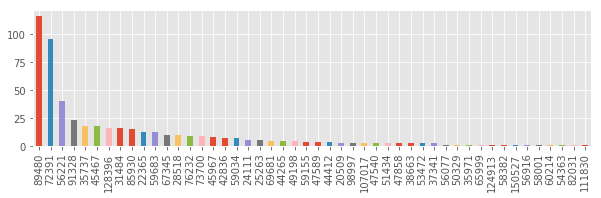

In [64]:
plt.figure(figsize=(10,2.5))
teste['CRM_EXECUTANTE'].value_counts().plot(kind='bar')

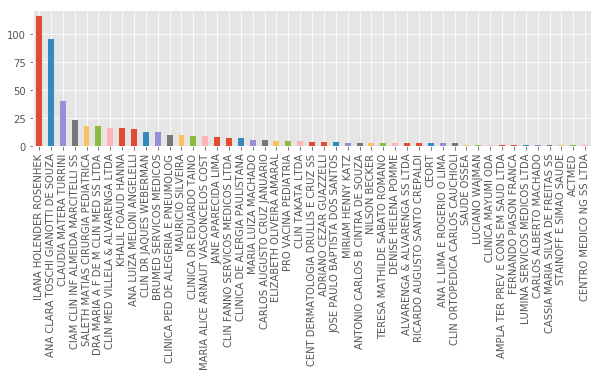

In [65]:
plt.figure(figsize=(10,2.5))
teste['NME_FANTASIA'].value_counts().plot(kind='bar')

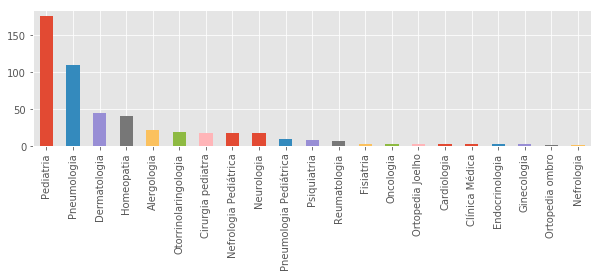

In [66]:
plt.figure(figsize=(10,2.5))
teste['Especialidade'].value_counts().plot(kind='bar')

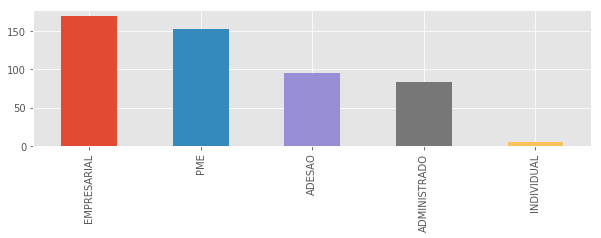

In [67]:
plt.figure(figsize=(10,2.5))
teste['CARTEIRA'].value_counts().plot(kind='bar')

In [68]:
fim = time.time()
time_proc = fim - ini
print('')
print('-------------------')
print('tempo de processamento: %fmin' %(time_proc/60))
print('-------------------')
today = datetime.datetime.now()
print('Hoje é %s/%s/%s, às %s:%2d' %(today.day,today.month, today.year, today.hour, today.minute))


-------------------
tempo de processamento: 4.142232min
-------------------
Hoje é 18/3/2019, às 7:39
